In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import plumed

In order to perform WHAM, I'm going to need:
- Files containing the timeseries data of my distance CV
- A metadata file pointing to all of the timeseries data files

I'm going to start with the first point here. I will need to restructure the format of the `COLVAR` files, and do some additional post-processing with `plumed driver` such that my COLVAR file has three columns:
1. Time
2. Distance (i.e. the instantenous CV value)
3. The total potential energy of the system in kJ/mol

Let's break this down into a few subproblems:
1. I need a PLUMED script that generates these files for me.
2. I need to do some file I/O that calls `plumed driver` and post processess all trajectories it can find from the list of `distances`.

Seems pretty simple. Let's get this working for two test distances first, and then we move on to the creation of the metadata file.

In [3]:
# Define the test_distances
distances = np.concatenate([np.arange(0.3,7.05,0.1).round(1),np.arange(0.61,0.77,0.05).round(2)])
extra = np.arange(0.61,0.77,0.05).round(2)
temps = [280, 300, 320]

In [2]:
# Define temps
temps = [280, 300, 320]

# Define distances
old_distances = np.arange(0.3,7.01,0.1).round(1) # First samplings
extra = np.arange(0.61,0.77,0.05).round(2) # Extra sampling in this region
new_distances = np.arange(0.35,7.05,0.1).round(2) # Even more sampling due to unexpected results
distances = np.concatenate([old_distances,extra,new_distances]) # concat everything
distances.sort()

# Store all sims in a nested dict. First dict is temps, second dict is distance: umbrella strength
sims = {temp : {dist: 150 for dist in distances} for temp in temps}
for temp in temps: 
    for x in extra: sims[temp][x] = 300 
    for x in new_distances: sims[temp][x] = 600 if x < 2.0 else 150

In [5]:
SKIP = 10000 # 10.000 x 0.002 ps = 20 ps or 2 ns
# Discarding the initial part of the trajectory 
for temp in temps:
    for dist in distances:
        if not os.path.exists(f'{temp}/{dist}/TIMESERIES'):
            continue
        elif os.path.exists(f'{temp}/{dist}/TIMESERIES_TRIMMED'):
            continue
        print(f'Now trimming {temp}/{dist}...')
        os.system(f'tail {temp}/{dist}/TIMESERIES -n +{SKIP} >> {temp}/{dist}/TIMESERIES_TRIMMED')


In [6]:
SKIP = 10000 # 10.000 x 0.002 ps = 20 ps or 2 ns

# Discarding the initial part of the trajectory 
for temp in sims.keys():
    for dist in sims[temp].keys():
        if not os.path.exists(f'{temp}/{dist}/TIMESERIES'):
            continue
        # elif os.path.exists(f'{temp}/{dist}/TIMESERIES_TRIMMED'):
        #     continue
        print(f'Now trimming {temp}/{dist}...')
        os.system(f'tail {temp}/{dist}/TIMESERIES -n +{SKIP} > {temp}/{dist}/TIMESERIES_TRIMMED')


Now trimming 280/0.3...
Now trimming 280/0.35...
Now trimming 280/0.4...
Now trimming 280/0.45...
Now trimming 280/0.5...
Now trimming 280/0.55...
Now trimming 280/0.6...
Now trimming 280/0.61...
Now trimming 280/0.65...
Now trimming 280/0.66...
Now trimming 280/0.7...
Now trimming 280/0.71...
Now trimming 280/0.75...
Now trimming 280/0.76...
Now trimming 280/0.8...
Now trimming 280/0.85...
Now trimming 280/0.9...
Now trimming 280/0.95...
Now trimming 280/1.0...
Now trimming 280/1.05...
Now trimming 280/1.1...
Now trimming 280/1.15...
Now trimming 280/1.2...
Now trimming 280/1.25...
Now trimming 280/1.3...
Now trimming 280/1.35...
Now trimming 280/1.4...
Now trimming 280/1.45...
Now trimming 280/1.5...
Now trimming 280/1.55...
Now trimming 280/1.6...
Now trimming 280/1.65...
Now trimming 280/1.7...
Now trimming 280/1.75...
Now trimming 280/1.8...
Now trimming 280/1.85...
Now trimming 280/1.9...
Now trimming 280/1.95...
Now trimming 280/2.0...
Now trimming 280/2.05...
Now trimming 280/2

## Part 2: Generating the metadata files

In [6]:
SPRING = 150
CORREL_TIME = 250 # 250 x 0.002 ps = 0.5 ps
max_dist = {280:0,
            300:0,
            320:0}

for temp in temps:
    with open(f'{temp}/metadata_{temp}.txt', 'w') as f:
        f.write('#/path/to/timeseries/file loc_win_min spring [correl time] [temperature]\n')
        
        for dist in distances:
            SPRING = 150
            if not os.path.exists(f'{temp}/{dist}/TIMESERIES_TRIMMED'):
                continue
            if dist in extra:
                SPRING = 300
            max_dist[temp] = max(max_dist[temp],dist)
            path = f'{temp}/{dist}/TIMESERIES_TRIMMED'
            line = ' '.join(map(str,[path, dist, SPRING, CORREL_TIME,'\n']))
            print(line)
            f.write(line)


280/0.3/TIMESERIES_TRIMMED 0.3 150 250 

280/0.4/TIMESERIES_TRIMMED 0.4 150 250 

280/0.5/TIMESERIES_TRIMMED 0.5 150 250 

280/0.6/TIMESERIES_TRIMMED 0.6 150 250 

280/0.7/TIMESERIES_TRIMMED 0.7 150 250 

280/0.8/TIMESERIES_TRIMMED 0.8 150 250 

280/0.9/TIMESERIES_TRIMMED 0.9 150 250 

280/1.0/TIMESERIES_TRIMMED 1.0 150 250 

280/1.1/TIMESERIES_TRIMMED 1.1 150 250 

280/1.2/TIMESERIES_TRIMMED 1.2 150 250 

280/1.3/TIMESERIES_TRIMMED 1.3 150 250 

280/1.4/TIMESERIES_TRIMMED 1.4 150 250 

280/1.5/TIMESERIES_TRIMMED 1.5 150 250 

280/1.6/TIMESERIES_TRIMMED 1.6 150 250 

280/1.7/TIMESERIES_TRIMMED 1.7 150 250 

280/1.8/TIMESERIES_TRIMMED 1.8 150 250 

280/1.9/TIMESERIES_TRIMMED 1.9 150 250 

280/2.0/TIMESERIES_TRIMMED 2.0 150 250 

280/2.1/TIMESERIES_TRIMMED 2.1 150 250 

280/2.2/TIMESERIES_TRIMMED 2.2 150 250 

280/2.3/TIMESERIES_TRIMMED 2.3 150 250 

280/2.4/TIMESERIES_TRIMMED 2.4 150 250 

280/2.5/TIMESERIES_TRIMMED 2.5 150 250 

280/2.6/TIMESERIES_TRIMMED 2.6 150 250 

280/2.7/TIMESERI

In [6]:

CORREL_TIME = 250 # 250 x 0.002 ps = 0.5 ps
max_dist = {280:0,
            300:0,
            320:0}

for temp in sims.keys():
    with open(f'{temp}/metadata_{temp}.txt', 'w') as f:
        # Generate header
        f.write('#/path/to/timeseries/file loc_win_min spring [correl time] [temperature]\n')
        
        for dist, spring in sims[temp].items():
            SPRING = 150
            
            # In case TRIMMED timeseries does not exist, skip
            if not os.path.exists(f'{temp}/{dist}/TIMESERIES_TRIMMED'):
                continue
            
            # Update max dist that we have in the metadata file
            max_dist[temp] = max(max_dist[temp],dist)
            
            # Write the line
            path = f'{temp}/{dist}/TIMESERIES_TRIMMED'
            line = ' '.join(map(str,[path, dist, spring, CORREL_TIME,'\n']))
            print(line)
            f.write(line)


280/0.3/TIMESERIES_TRIMMED 0.3 150 250 

280/0.35/TIMESERIES_TRIMMED 0.35 600 250 

280/0.4/TIMESERIES_TRIMMED 0.4 150 250 

280/0.45/TIMESERIES_TRIMMED 0.45 600 250 

280/0.5/TIMESERIES_TRIMMED 0.5 150 250 

280/0.55/TIMESERIES_TRIMMED 0.55 600 250 

280/0.6/TIMESERIES_TRIMMED 0.6 150 250 

280/0.61/TIMESERIES_TRIMMED 0.61 300 250 

280/0.65/TIMESERIES_TRIMMED 0.65 600 250 

280/0.66/TIMESERIES_TRIMMED 0.66 300 250 

280/0.7/TIMESERIES_TRIMMED 0.7 150 250 

280/0.71/TIMESERIES_TRIMMED 0.71 300 250 

280/0.75/TIMESERIES_TRIMMED 0.75 600 250 

280/0.76/TIMESERIES_TRIMMED 0.76 300 250 

280/0.8/TIMESERIES_TRIMMED 0.8 150 250 

280/0.85/TIMESERIES_TRIMMED 0.85 600 250 

280/0.9/TIMESERIES_TRIMMED 0.9 150 250 

280/0.95/TIMESERIES_TRIMMED 0.95 600 250 

280/1.0/TIMESERIES_TRIMMED 1.0 150 250 

280/1.05/TIMESERIES_TRIMMED 1.05 600 250 

280/1.1/TIMESERIES_TRIMMED 1.1 150 250 

280/1.15/TIMESERIES_TRIMMED 1.15 600 250 

280/1.2/TIMESERIES_TRIMMED 1.2 150 250 

280/1.25/TIMESERIES_TRIMMED 1.2

## Part 3: Running WHAM

In [8]:
for temp in [280]:
    if os.path.exists(f'free_{temp}_new.txt'):
        continue
    if not os.path.exists(f'{temp}/metadata_{temp}.txt'):
        continue
    print(f'~/wham/wham/wham 0.3 {max_dist[temp]} 150 0.0001 {temp} 0 {temp}/metadata_{temp}.txt free_{temp}_new.txt 100 0')
    os.system(f'~/wham/wham/wham 0.3 {max_dist[temp]} 150 0.0001 {temp} 0 {temp}/metadata_{temp}.txt free_{temp}_new.txt 100 0')

~/wham/wham/wham 0.3 7.0 150 0.0001 280 0 280/metadata_280.txt free_280_new.txt 100 0
# /scistor/informatica/age206/wham/wham/wham 0.3 7.0 150 0.0001 280 0 280/metadata_280.txt free_280_new.txt 100 0
#Number of windows = 139
#Iteration 10:  0.301334
#Iteration 20:  0.211312
#Iteration 30:  0.164509
#Iteration 40:  0.133507
#Iteration 50:  0.111147
#Iteration 60:  0.094270
#Iteration 70:  0.081133
#Iteration 80:  0.070668
#Iteration 90:  0.062172
#Iteration 100:  0.055166
0.322333	inf	0.000000
0.367000	22.788581	0.000143
0.411667	13.360558	0.008208
0.456333	5.726893	0.217909
0.501000	0.642717	1.935182
0.545667	0.000000	2.550467
0.590333	4.278646	0.405923
0.635000	9.846188	0.037139
0.679667	22.042533	0.000197
0.724333	20.095372	0.000455
0.769000	14.148674	0.005851
0.813667	12.216581	0.013416
0.858333	12.560694	0.011573
0.903000	14.001847	0.006232
0.947667	16.585726	0.002054
0.992333	18.231729	0.001013
1.037000	18.790818	0.000797
1.081667	19.361363	0.000623
1.126333	19.846033	0.000506
1.1

## Part 4: Visualizing the free energy

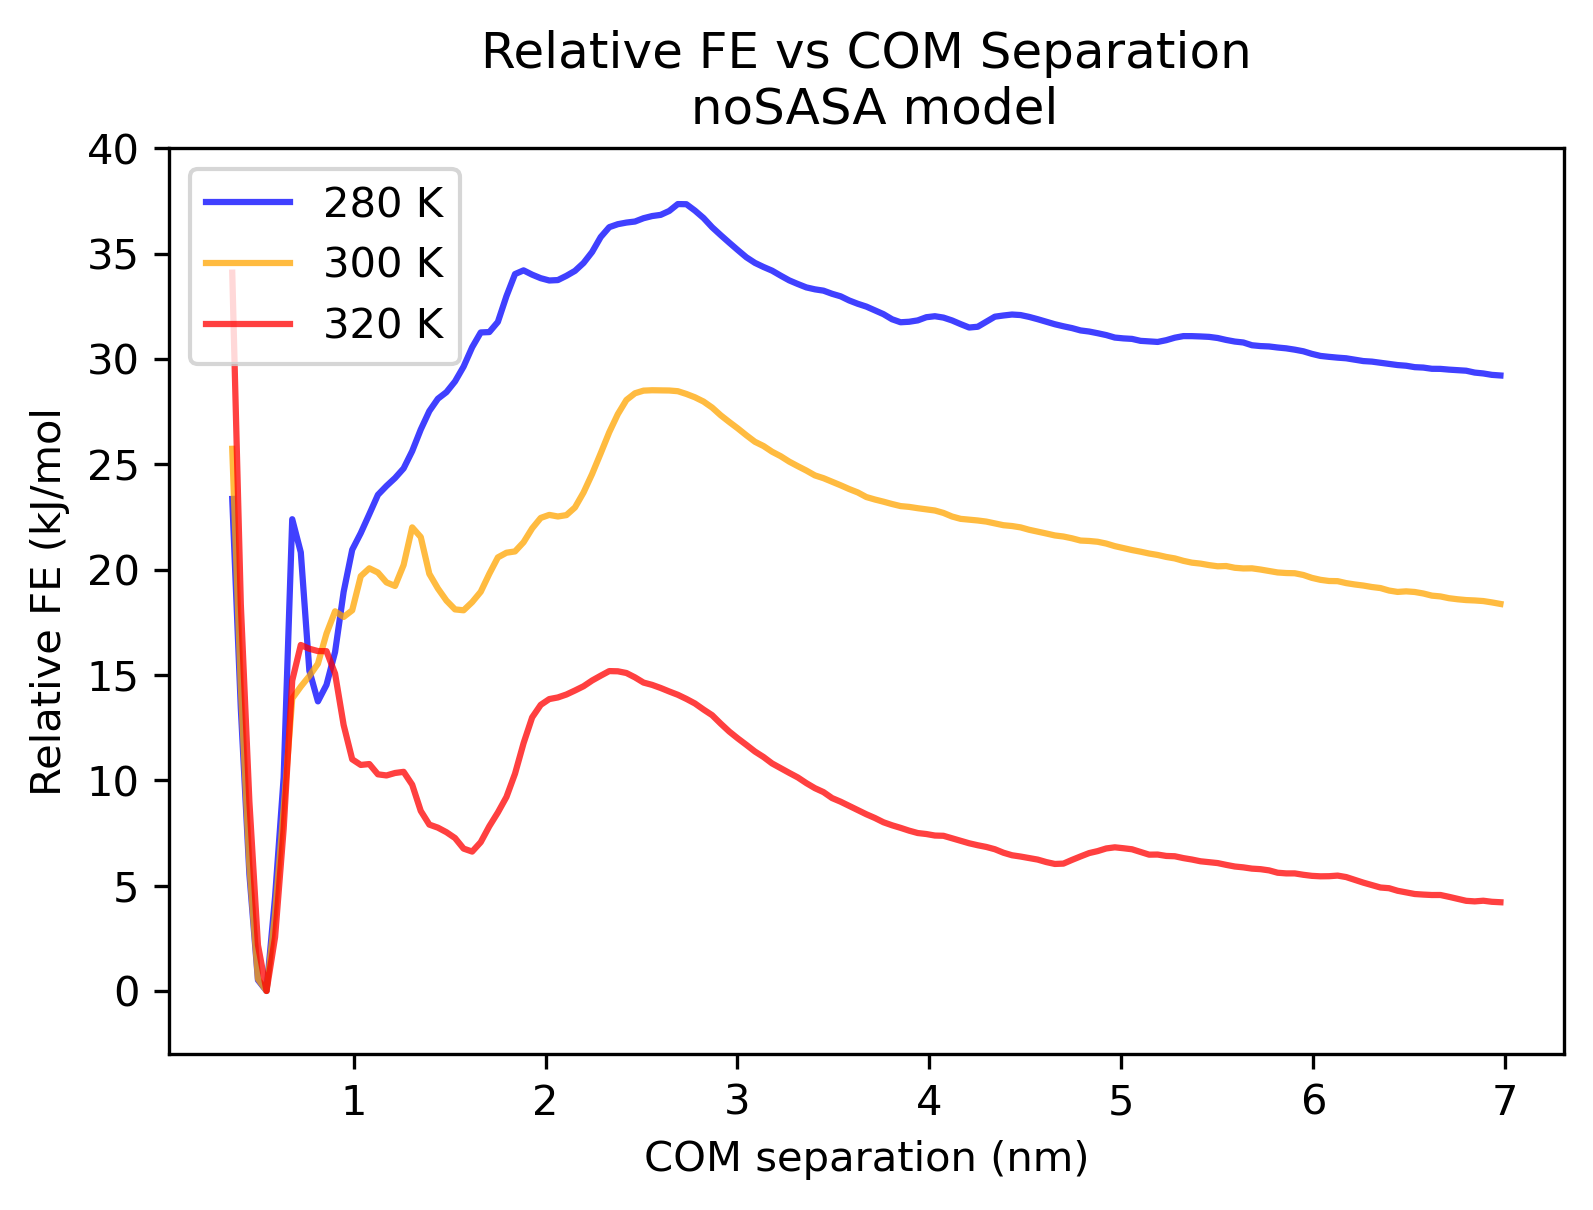

In [5]:
cols = ['blue','orange','red']

plt.figure(dpi=300)
for i, temp in enumerate(temps):
    if not os.path.exists(f'free_{temp}_new.txt'):
        continue
    fes = pd.read_csv(f'free_{temp}_new.txt', sep='\t', comment='#', names=['dist','free','error','prob','proberror'])
    plt.plot(fes['dist'],fes['free'], label=f'{temp} K', color=cols[i], alpha=0.75)
plt.legend()
plt.title('Relative FE vs COM Separation\n noSASA model')
plt.ylabel('Relative FE (kJ/mol)')
plt.ylim([-3,40])
plt.xlabel('COM separation (nm)')
plt.savefig('FES_all_noSASA.png')

/scistor/informatica/age206/.conda/envs/AnalysisTools/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: cannot load PLUMED instance, conversions will not be available
  app.launch_new_instance()
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
++

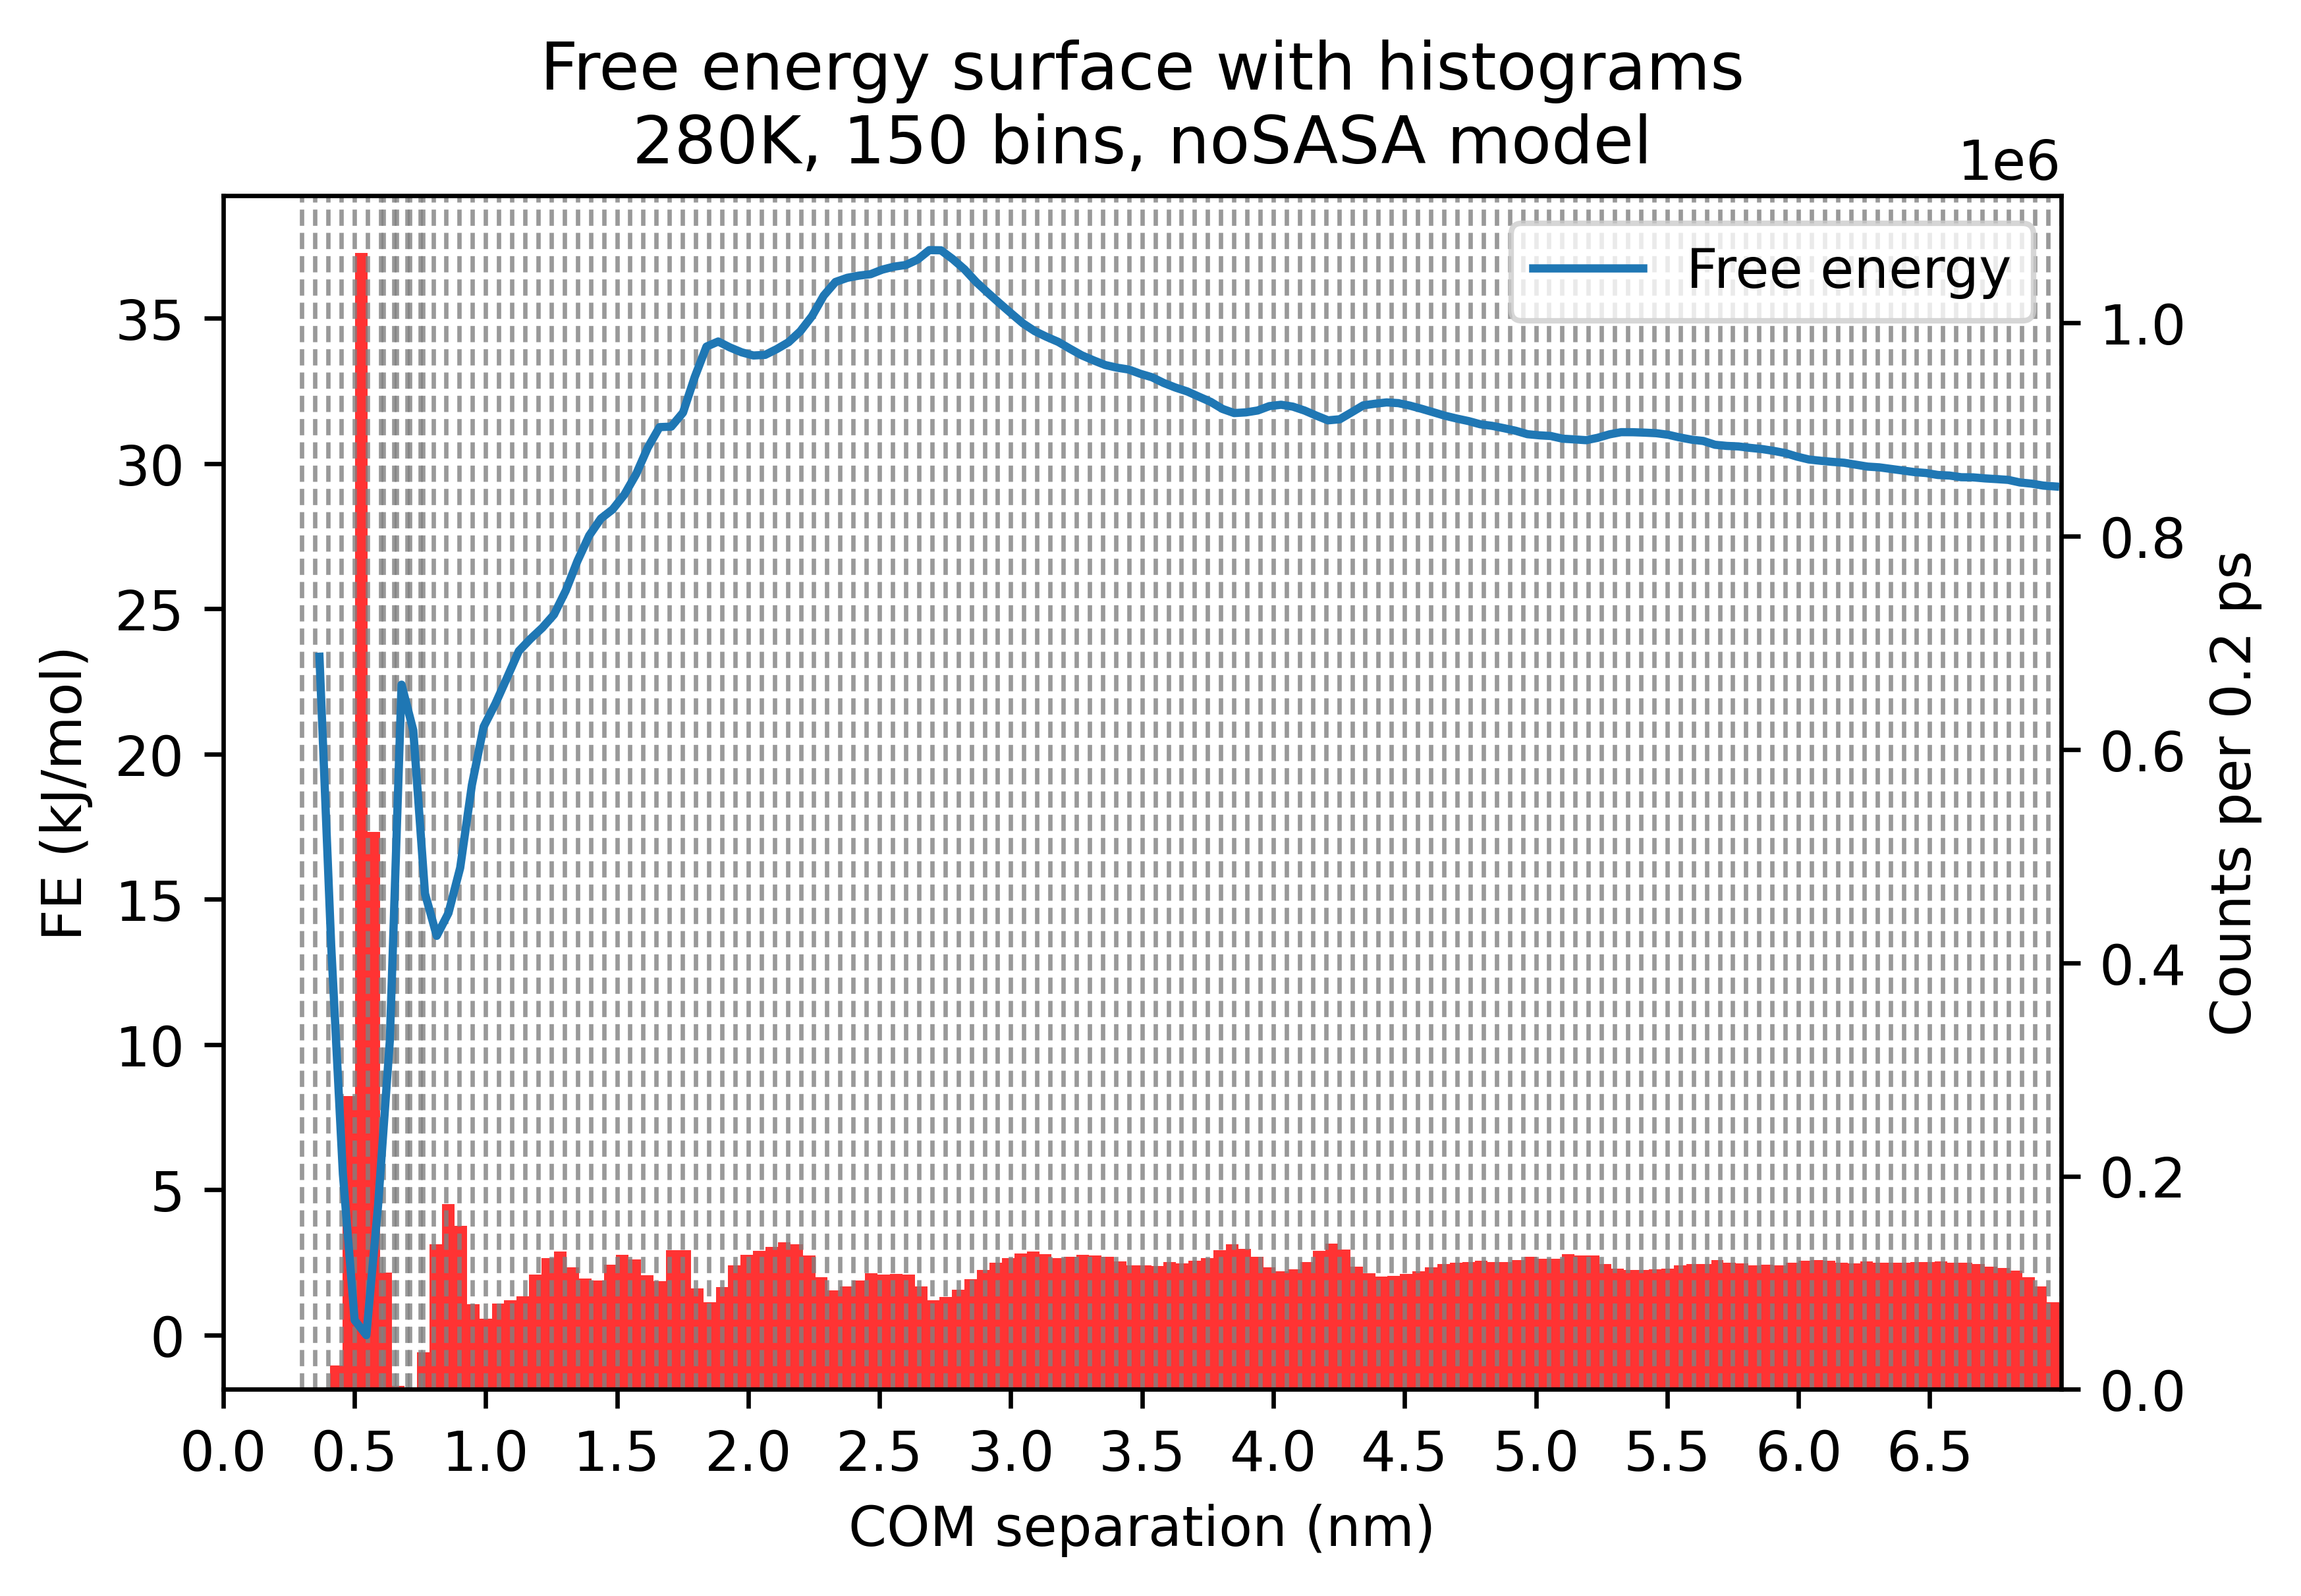

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
/scistor/informatica/age206/.conda/envs/AnalysisTools/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: cannot load PLUMED instance, conversions will not be available
  app.launch_new_instance()
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
++

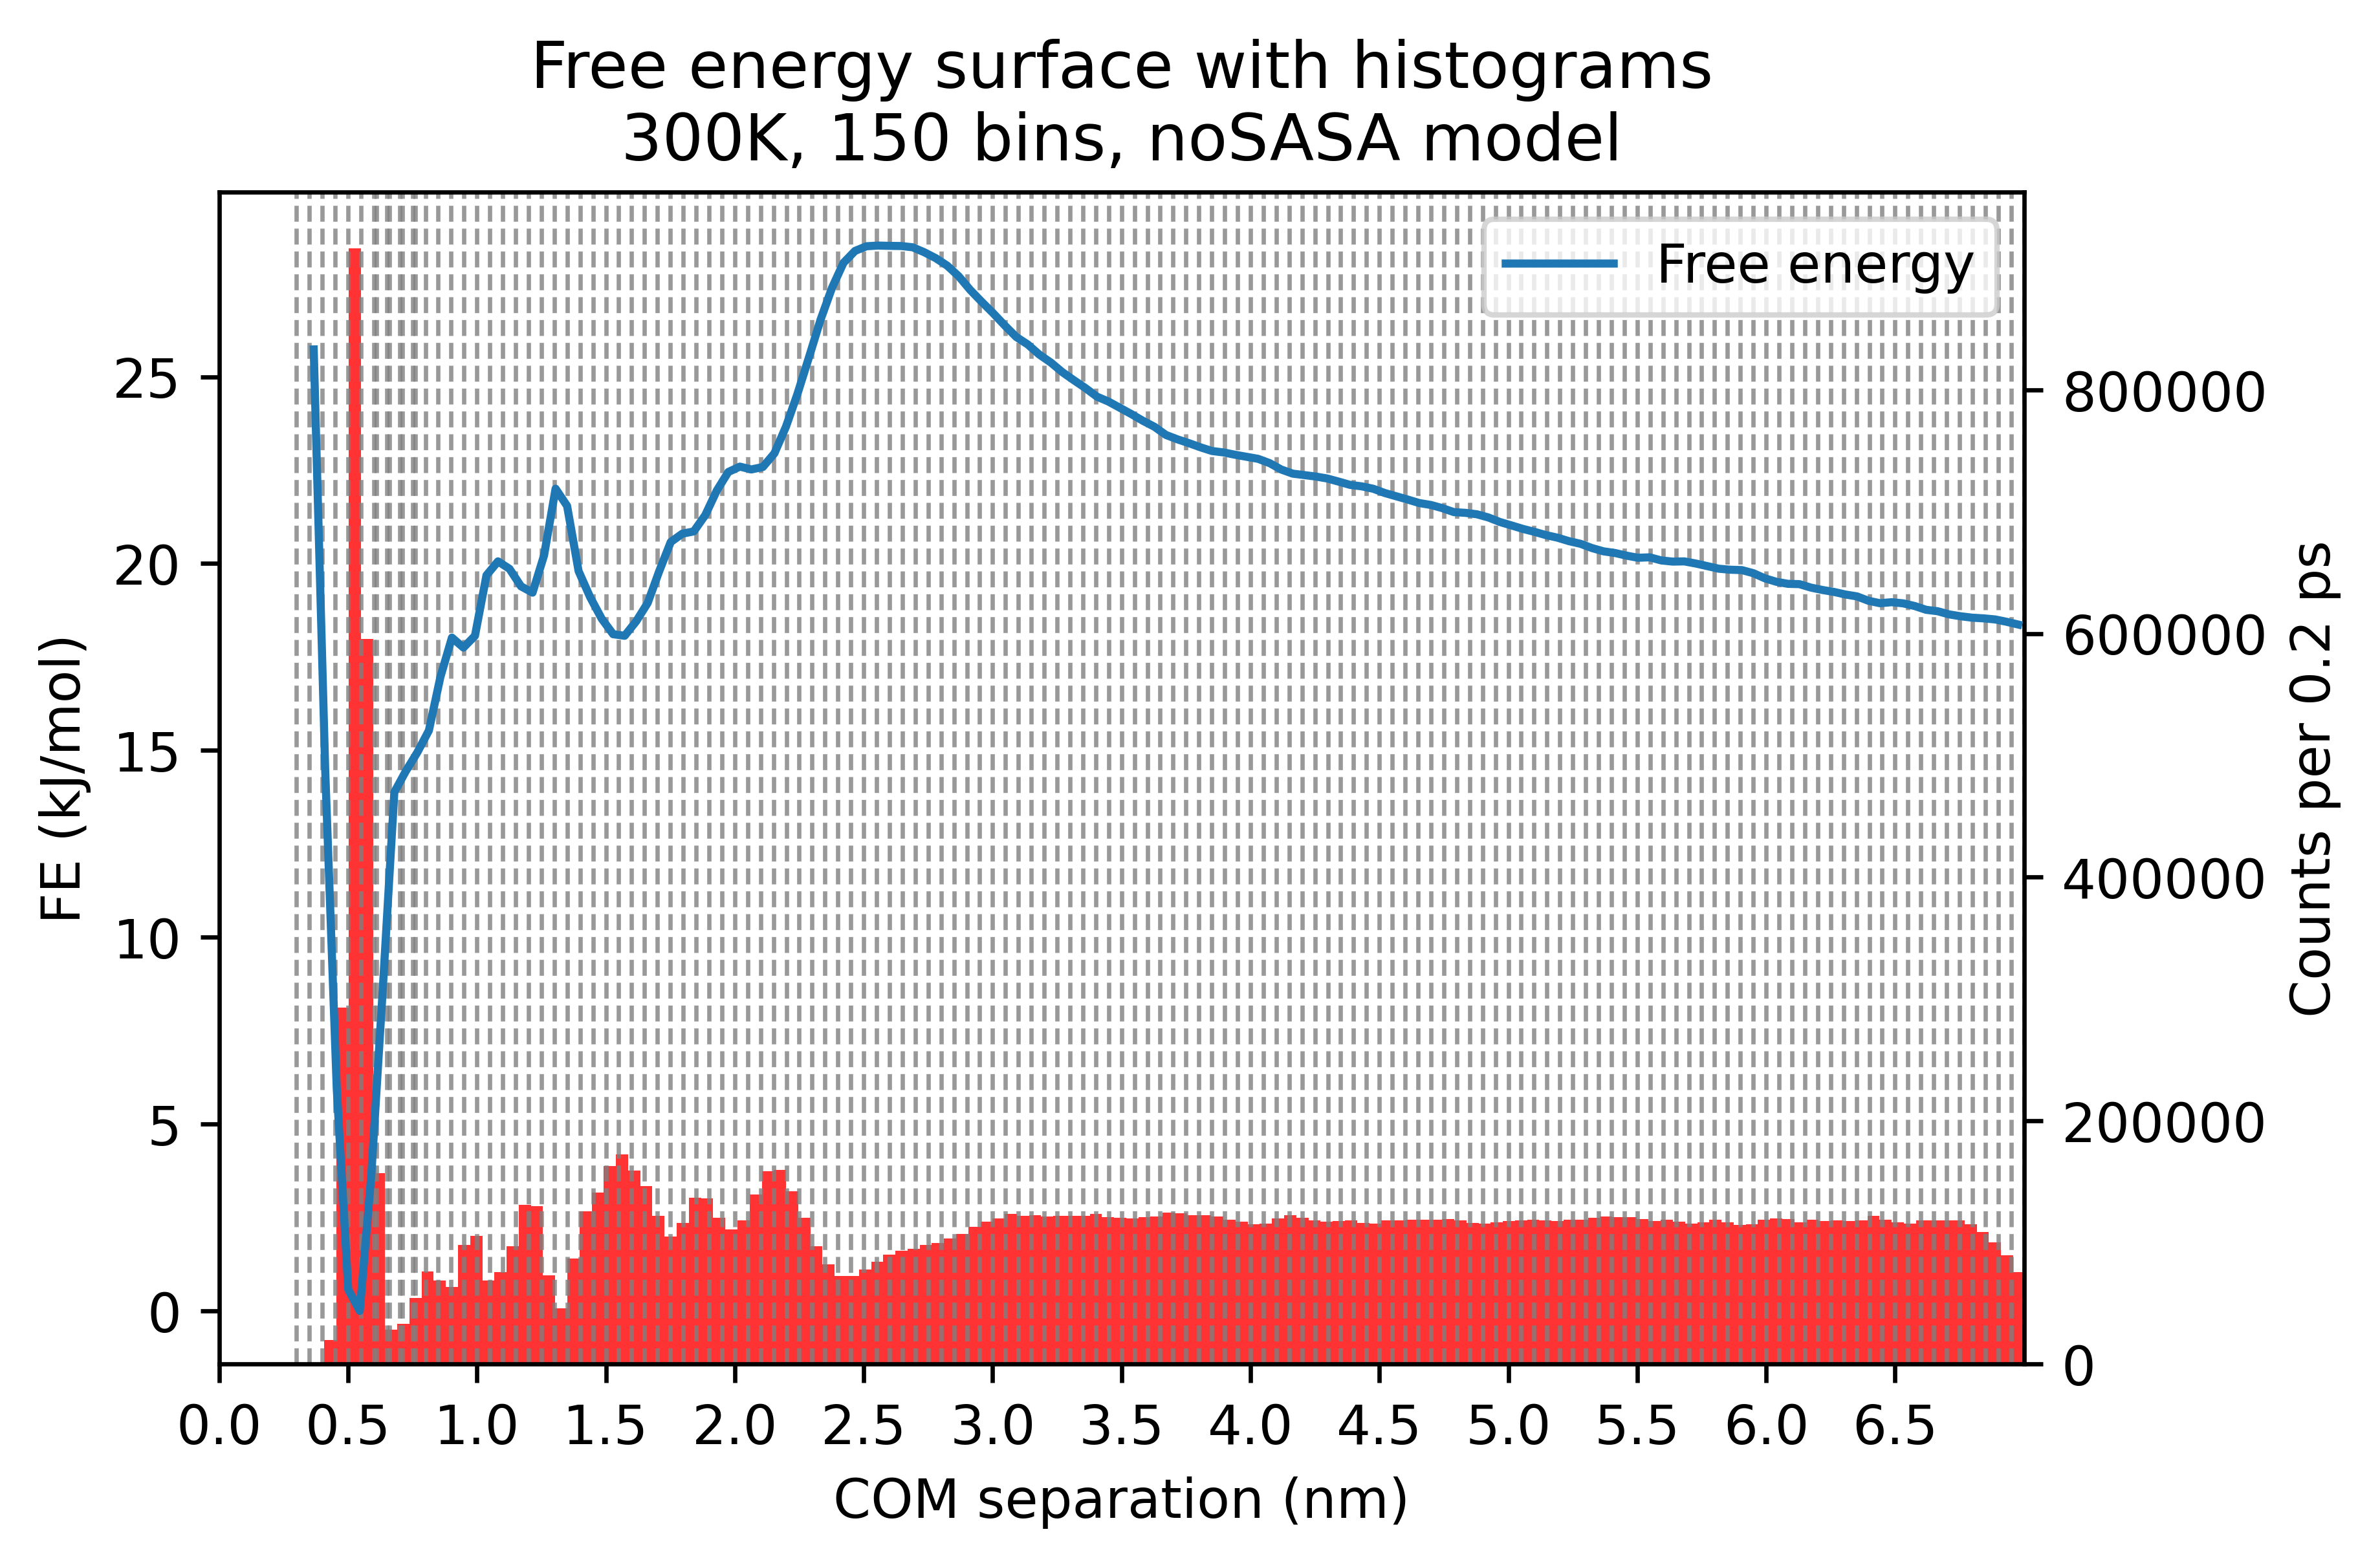

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
/scistor/informatica/age206/.conda/envs/AnalysisTools/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: cannot load PLUMED instance, conversions will not be available
  app.launch_new_instance()
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/scistor/informatica/age206/plumed/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
++

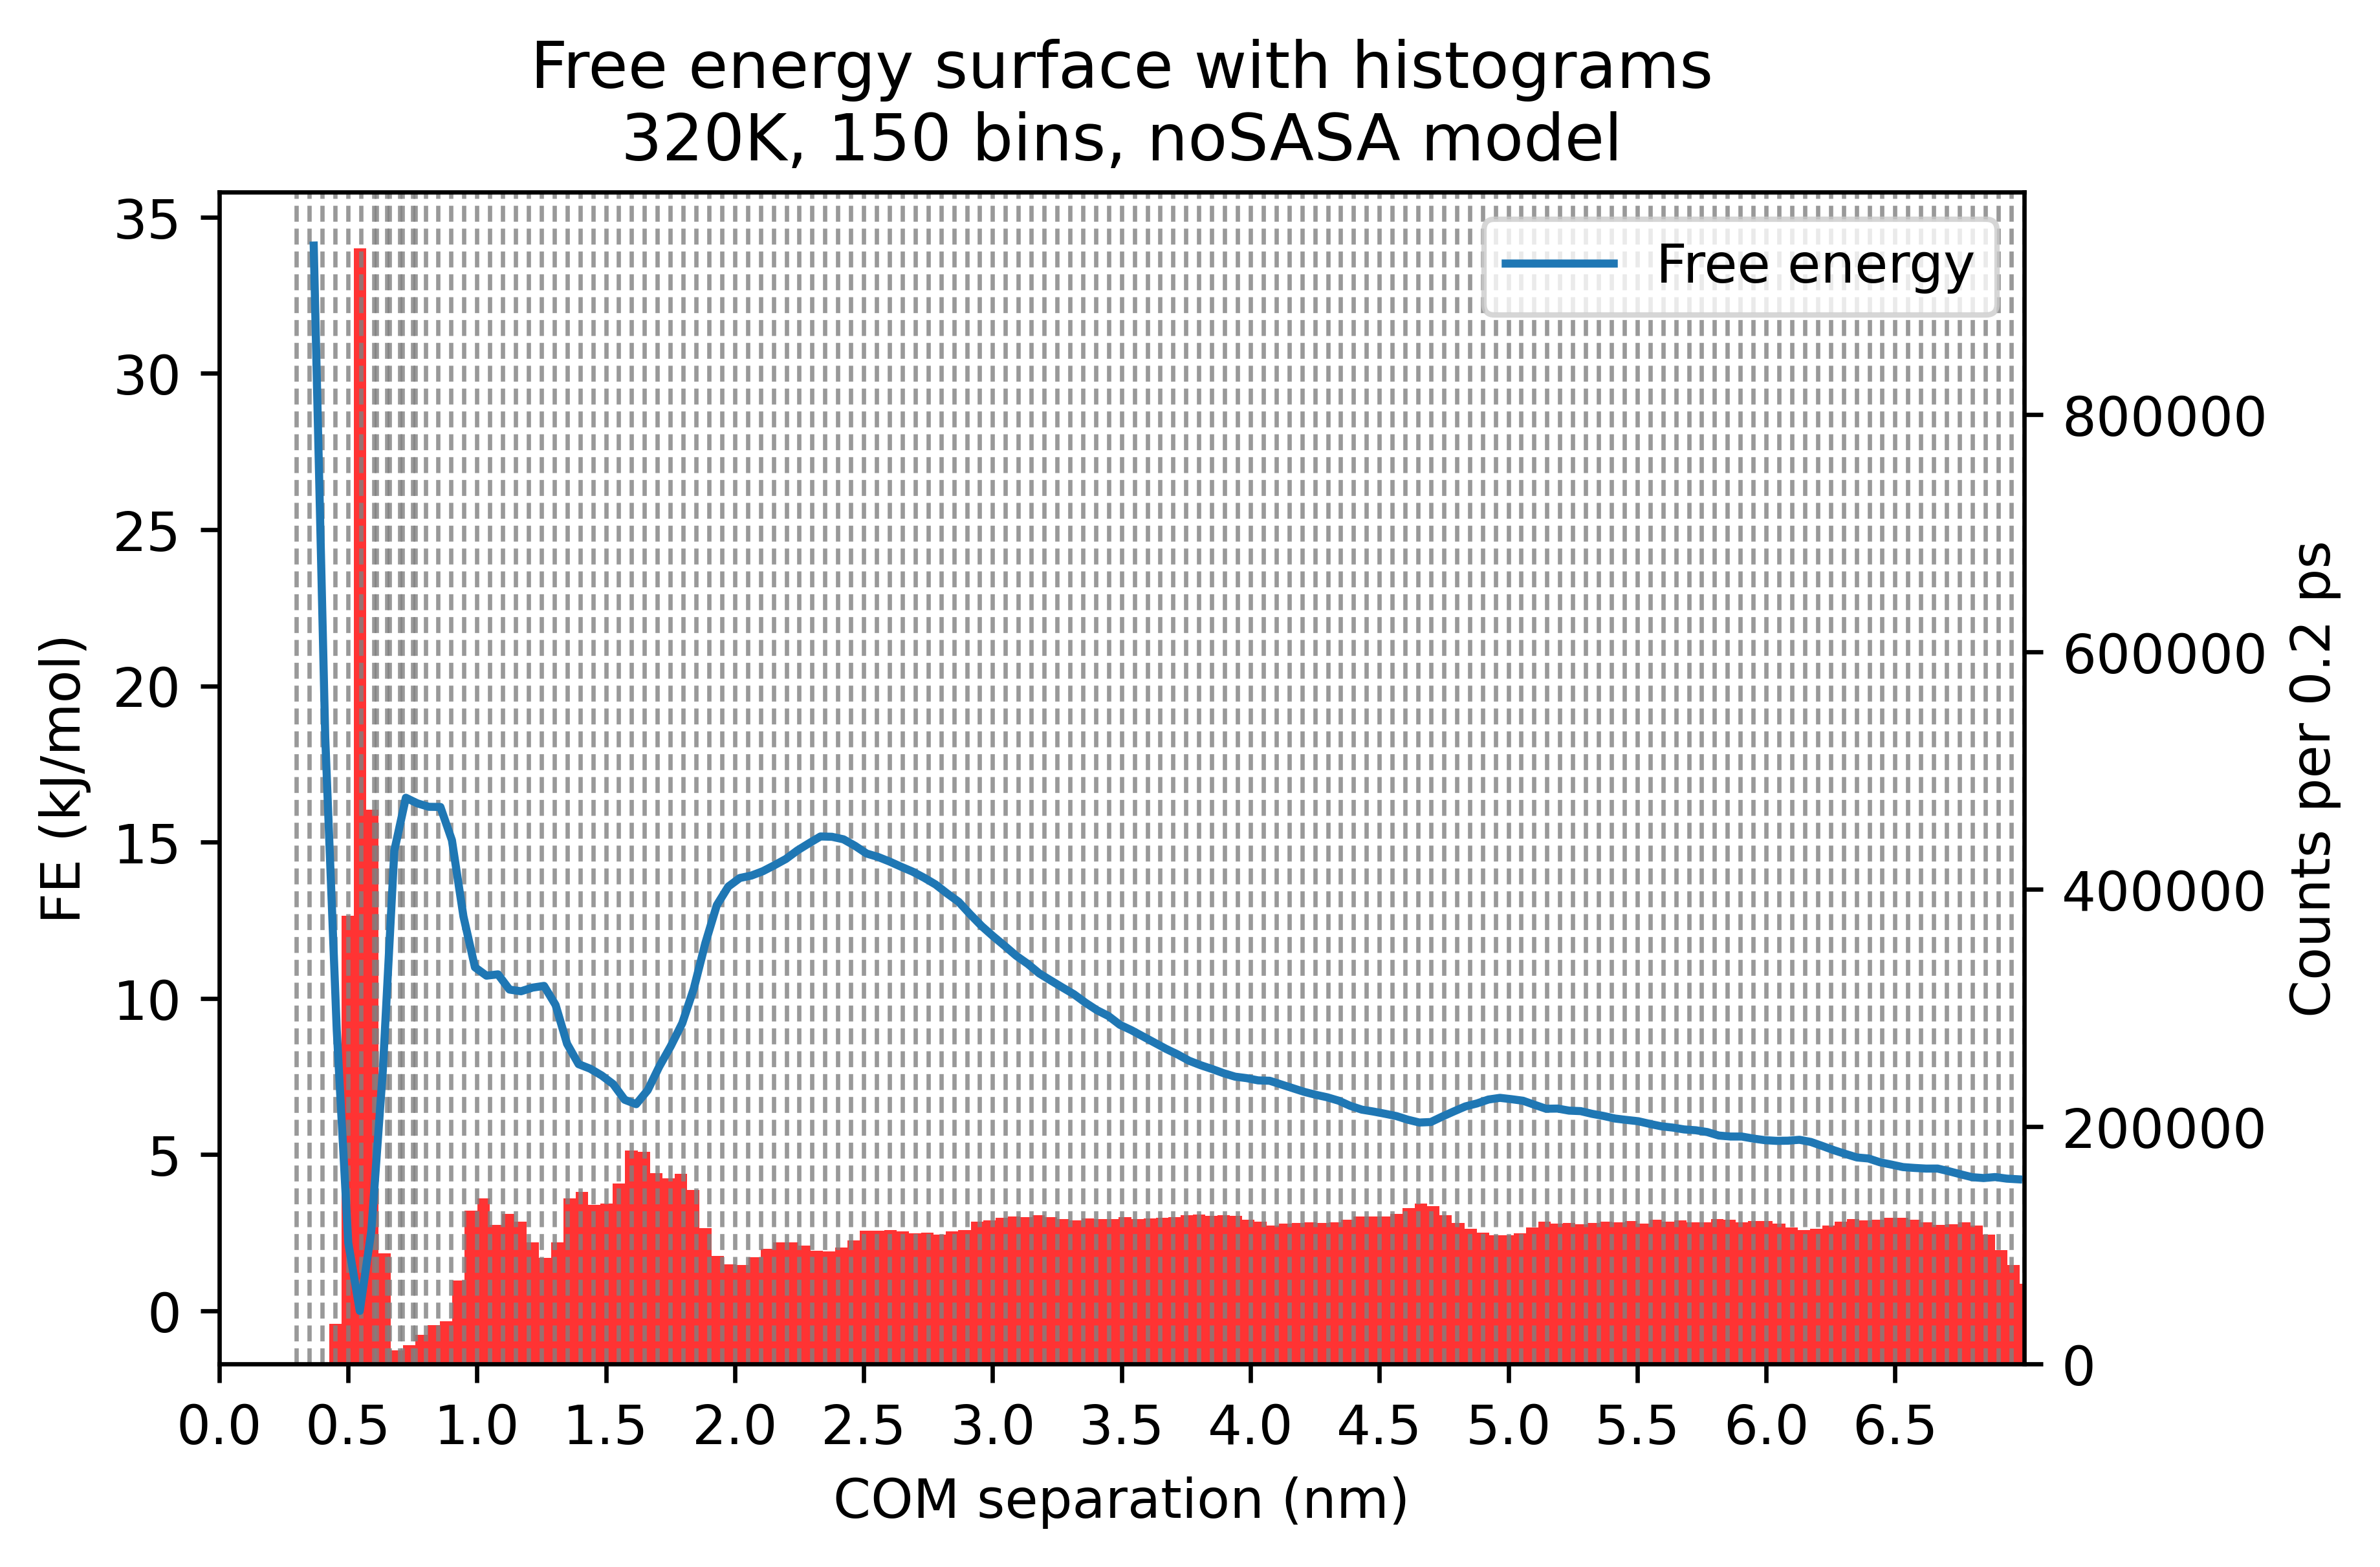

In [4]:
BINS=150
max_dist = {280: 7.0, 300:7.0, 320:7.0}

for temp in temps:    
    if not os.path.exists(f'free_{temp}_new.txt'):
        continue
    
    total = np.array([])
    umb = np.array([])
    
    for dist in distances:
        if not os.path.exists(f'{temp}/{dist}/COLVAR'):
            print(f'skipping {temp}/{dist}/COLVAR')
            continue
        
        t = plumed.read_as_pandas(f'{temp}/{dist}/COLVAR')
        total = np.concatenate([total,t['dist'].values])
        umb = np.concatenate([umb,t['umbrella.bias']])
    
    fes = pd.read_csv(f'free_{temp}_new.txt', sep='\t', comment='#', names=['dist','free','error','prob','proberror'])
    
    # Initialize plot
    fig=plt.figure(dpi=600)
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)
    
    # Histogram
    ax.hist(total,bins=BINS, alpha=0.8, color='red', label='Counts')
    ax.yaxis.tick_right()
    ax.set_ylabel('Counts per 0.2 ps')
    ax.set_xlabel('COM separation (nm)')
    ax.yaxis.set_label_position('right')
    ax.set_xticks(np.arange(0,max_dist[temp],0.5))
    ax.set_xlim([0,max_dist[temp]])


    ax2.plot(fes['dist'],fes['free'], label='Free energy')
    ax2.set_ylabel('FE (kJ/mol)')
    ax2.set_xticks([])
    ax2.set_xlim([0,max_dist[temp]])

                              
#     ax3.scatter(total[::2],[22 for t in total[::2]],alpha=0.3, s=0.5,c=umb[::2],cmap='gray')
#     ax3.set_xticks(np.arange(0.3,1.2,0.1))
#     ax3.set_xlim([0.3,1.2])
#     ax3.set_ylim([0, 25])
#     ax3.set_yticks([])
    
#     ax3.scatter(total[1::2],[24 for t in total[1::2]],alpha=0.3, s=0.5,c=umb[1::2])
#     ax3.set_xticks(np.arange(0.3,1.2,0.1))
#     ax3.set_xlim([0.3,1.2])
#     ax3.set_ylim([0, 25])
#     ax3.set_yticks([])
    
    # Set vertical lines for umbreall Windows
    for dist in distances:
        ax.axvline(x=dist, color='gray', linestyle='--', linewidth=0.8, alpha=0.8)
    # ax.axvline(x=7.1, color='gray', linestyle='--', linewidth=0.8, alpha=0.3, label='Umbrella windows')

    plt.title(f'Free energy surface with histograms\n{temp}K, {BINS} bins, noSASA model')
    plt.legend()
    fig.savefig(f'Sampling_fes_{temp}.png')
    plt.show()

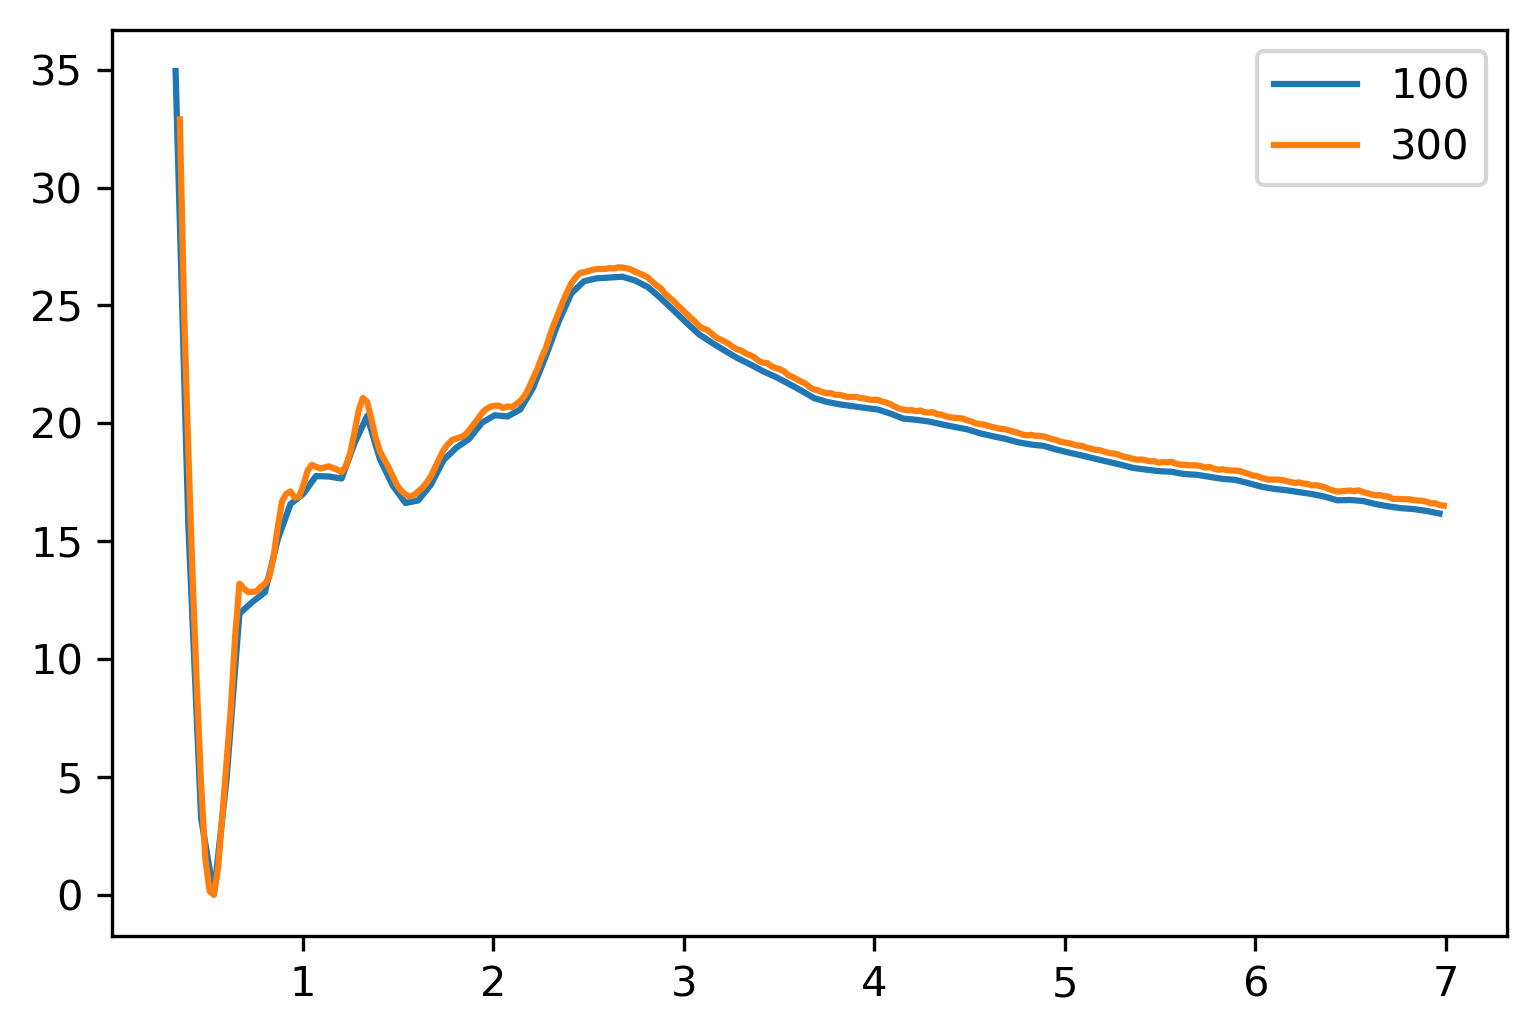

In [19]:
bins = [100,300]
plt.figure(dpi=300)
for b in bins:
    t = pd.read_csv(f'free_300_new_{b}.txt', sep='\t', comment='#', names=['dist','free','error','prob','proberror'])
    plt.plot(t['dist'],t['free'],label=str(b))
plt.legend()